In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random
import numpy as np
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
!pip install catboost

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6969791845931163932
xla_global_id: -1
]


In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


In [5]:
batch_size = 1000
testsplit = .5
targetx = 100
targety = 100
learning_rate = 0.0001
classes = 7
seed = random.randint(1, 1000)
print(seed)
target_names=['angry','disgust','fear','happy','neutral','sad','surprise']

data_dir = "/kaggle/input/raf-db-dataset/DATASET/train/"
data_dir1 = "/kaggle/input/raf-db-dataset/DATASET/test/"

385


In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
       
)

test_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed
)


Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


/kaggle/input/raf-db-dataset/DATASET/train/4/train_04237_aligned.jpg


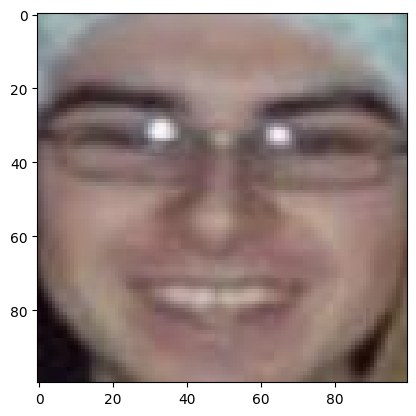

In [7]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [8]:
features_extractor = InceptionV3(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))


87910968/87910968 [==============================] - 3s 0us/step


In [18]:
def features_numpy_extract(gen,exit_num):
    gen.reset()
    features_before= None
    label_before = None
    first = True
    batch_num = 0
    for data_batch in gen:
        features = features_extractor(data_batch[0])
        print(batch_num)
        batch_num+=1
        length = features.shape[0]
        features = tf.reshape(features,(length,2048))
        features = features.numpy()

        label = tf.math.argmax(data_batch[1],1)
        label = label.numpy()
        if first:
            features_before= features
            label_before = label
            first = False
            continue 
        features_before = np.concatenate((features_before,features),axis=0)
        label_before = np.concatenate((label_before,label),axis=None)
        if batch_num>exit_num:
            break
        
    return features_before,label_before


In [19]:
print('train')
# 12271
# 3068
feat_train, label_train =features_numpy_extract(train_generator,13)
print('test')
feat_test, label_test =features_numpy_extract(test_generator,3)

train
0
1
2
3
4
5
6
7
8
9
10
11
12
13
test
0
1
2
3


In [20]:
print(feat_train.shape)
print(feat_test.shape)
print(label_train.shape)
print(label_test.shape)

(13271, 2048)
(3068, 2048)
(13271,)
(3068,)


In [21]:
import optuna

import catboost as cb
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

def objective(trial):
    x, xt, y, yt = feat_train,feat_test,label_train,label_test
    param = {
        "objective": trial.suggest_categorical("objective", ["MultiClass", "MultiClassOneVsAll"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "used_ram_limit": "25gb",
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 4, 200),
        'max_bin': trial.suggest_int('max_bin', 100, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        'random_seed': 42,
        'task_type': 'CPU',
        'eval_metric': 'Accuracy',
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    pca_param ={
        "n_components": trial.suggest_float("n_components", 0.5, 0.9999),
        'power_iteration_normalizer': trial.suggest_categorical('power_iteration_normalizer',
            ['auto', 'QR', 'LU', 'none']
        ),
        'svd_solver':'full',

    }
    
    pca = PCA(**pca_param).fit(x,y)
    x = pca.transform(x)
    xt = pca.transform(xt)
    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(x, y, eval_set=[(xt, yt)], verbose=0, early_stopping_rounds=10)
    preds = gbm.predict(xt)
    pred_labels = np.rint(preds)

    ac = gbm.get_best_score()['validation']['Accuracy']
    print(ac)
    return ac

In [23]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, timeout=600, n_jobs=-1)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-21 20:18:05,202] A new study created in memory with name: no-name-9cf86a96-8dd4-4cc8-b283-26556838276b
[I 2023-10-21 20:18:34,431] Trial 3 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.03433077953745847, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 49, 'max_bin': 159, 'min_data_in_leaf': 246, 'l2_leaf_reg': 0.0019423430402168943, 'bagging_temperature': 6.165625183314254, 'n_components': 0.866929006837426, 'power_iteration_normalizer': 'none'}. Best is trial 3 with value: 0.386245110821382.
[I 2023-10-21 20:18:34,604] Trial 2 finished with value: 0.38657105606258146 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08651101574904081, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 66, 'max_bin': 276, 'min_data_in_leaf': 256, 'l2_leaf_reg': 0.00014805904867037735, 'bagging_te

0.386245110821382
0.38657105606258146


[I 2023-10-21 20:18:48,278] Trial 0 finished with value: 0.3882007822685789 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06315292630846892, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 3, 'learning_rate': 0.02, 'n_estimators': 6, 'max_bin': 396, 'min_data_in_leaf': 82, 'l2_leaf_reg': 0.38560953102781875, 'subsample': 0.9998283730015789, 'n_components': 0.9473515386795114, 'power_iteration_normalizer': 'QR'}. Best is trial 0 with value: 0.3882007822685789.
[I 2023-10-21 20:18:48,290] Trial 1 finished with value: 0.39276401564537156 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06281064414800244, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 4, 'learning_rate': 0.02, 'n_estimators': 43, 'max_bin': 233, 'min_data_in_leaf': 224, 'l2_leaf_reg': 0.006404914567484927, 'subsample': 0.25835241764329575, 'n_components': 0.8775658270102187, 'power_iteration_normalizer': 'auto'}. Best is trial 1 with va

0.3882007822685789
0.39276401564537156


[I 2023-10-21 20:18:49,216] Trial 4 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.0348670437251779, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 7, 'learning_rate': 0.005, 'n_estimators': 17, 'max_bin': 318, 'min_data_in_leaf': 2, 'l2_leaf_reg': 0.03866224534900891, 'subsample': 0.5591943345712346, 'n_components': 0.80949847624483, 'power_iteration_normalizer': 'LU'}. Best is trial 1 with value: 0.39276401564537156.


0.386245110821382


[I 2023-10-21 20:19:10,830] Trial 5 finished with value: 0.43709256844850064 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.07763918119510917, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 86, 'max_bin': 312, 'min_data_in_leaf': 266, 'l2_leaf_reg': 0.9500795176032607, 'bagging_temperature': 3.693560612903406, 'n_components': 0.8430939547049, 'power_iteration_normalizer': 'auto'}. Best is trial 5 with value: 0.43709256844850064.


0.43709256844850064


[I 2023-10-21 20:19:25,000] Trial 6 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06395422343926745, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 4, 'learning_rate': 0.02, 'n_estimators': 74, 'max_bin': 259, 'min_data_in_leaf': 176, 'l2_leaf_reg': 0.00010804611405257755, 'subsample': 0.8461504499718384, 'n_components': 0.5867410632711871, 'power_iteration_normalizer': 'LU'}. Best is trial 5 with value: 0.43709256844850064.
[I 2023-10-21 20:19:25,190] Trial 7 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.014920602986439558, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 11, 'max_bin': 200, 'min_data_in_leaf': 169, 'l2_leaf_reg': 0.03940045151116205, 'subsample': 0.1124640643235782, 'n_components': 0.6993883984322312, 'power_iteration_normalizer': 'LU'}. Best is trial 5 w

0.386245110821382
0.386245110821382


[I 2023-10-21 20:19:25,734] Trial 8 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.09123000465300814, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 72, 'max_bin': 398, 'min_data_in_leaf': 3, 'l2_leaf_reg': 0.004265173574354452, 'subsample': 0.7723172126234696, 'n_components': 0.5032717162537049, 'power_iteration_normalizer': 'none'}. Best is trial 5 with value: 0.43709256844850064.


0.386245110821382


[I 2023-10-21 20:19:40,132] Trial 9 finished with value: 0.38689700130378096 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.03903752431218666, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 56, 'max_bin': 376, 'min_data_in_leaf': 285, 'l2_leaf_reg': 0.0003670705150619057, 'bagging_temperature': 2.0086561326677854, 'n_components': 0.9307985077617249, 'power_iteration_normalizer': 'QR'}. Best is trial 5 with value: 0.43709256844850064.


0.38689700130378096


[I 2023-10-21 20:19:54,555] Trial 10 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.03476479265875621, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 4, 'learning_rate': 0.005, 'n_estimators': 45, 'max_bin': 329, 'min_data_in_leaf': 64, 'l2_leaf_reg': 0.00024856602468989496, 'bagging_temperature': 2.029822916987154, 'n_components': 0.9142813790796673, 'power_iteration_normalizer': 'none'}. Best is trial 5 with value: 0.43709256844850064.


0.386245110821382


[I 2023-10-21 20:19:55,169] Trial 11 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.04791234995514099, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.005, 'n_estimators': 96, 'max_bin': 118, 'min_data_in_leaf': 266, 'l2_leaf_reg': 0.004697454501499959, 'bagging_temperature': 7.369082942871048, 'n_components': 0.5947279755680507, 'power_iteration_normalizer': 'QR'}. Best is trial 5 with value: 0.43709256844850064.


0.386245110821382


[I 2023-10-21 20:19:55,450] Trial 12 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.05591078524563262, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 95, 'max_bin': 270, 'min_data_in_leaf': 223, 'l2_leaf_reg': 0.0017272009903251933, 'bagging_temperature': 8.122053684561774, 'n_components': 0.8403836188379772, 'power_iteration_normalizer': 'QR'}. Best is trial 5 with value: 0.43709256844850064.


0.386245110821382


[I 2023-10-21 20:20:44,044] Trial 13 finished with value: 0.39276401564537156 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.09688507832742609, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 91, 'max_bin': 323, 'min_data_in_leaf': 105, 'l2_leaf_reg': 0.6062693094874315, 'bagging_temperature': 9.759994912298886, 'n_components': 0.9974016068665247, 'power_iteration_normalizer': 'auto'}. Best is trial 5 with value: 0.43709256844850064.


0.39276401564537156


[I 2023-10-21 20:20:59,743] Trial 14 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.07764788731719922, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 32, 'max_bin': 108, 'min_data_in_leaf': 216, 'l2_leaf_reg': 0.7970353256496441, 'bagging_temperature': 8.628373618097138, 'n_components': 0.8201396732332623, 'power_iteration_normalizer': 'auto'}. Best is trial 5 with value: 0.43709256844850064.


0.386245110821382


[I 2023-10-21 20:21:00,843] Trial 17 finished with value: 0.3875488917861799 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.07614978970843637, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 7, 'learning_rate': 0.02, 'n_estimators': 30, 'max_bin': 215, 'min_data_in_leaf': 209, 'l2_leaf_reg': 0.14267891612928624, 'subsample': 0.19889314907899155, 'n_components': 0.7841338809526489, 'power_iteration_normalizer': 'auto'}. Best is trial 5 with value: 0.43709256844850064.


0.3875488917861799


[I 2023-10-21 20:21:32,989] Trial 16 finished with value: 0.3875488917861799 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.07911368118312041, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 8, 'learning_rate': 0.02, 'n_estimators': 29, 'max_bin': 201, 'min_data_in_leaf': 218, 'l2_leaf_reg': 0.766015220030921, 'subsample': 0.18503201962526394, 'n_components': 0.999050170347175, 'power_iteration_normalizer': 'auto'}. Best is trial 5 with value: 0.43709256844850064.
[I 2023-10-21 20:21:32,996] Trial 15 finished with value: 0.39080834419817473 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.07513654484751353, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 32, 'max_bin': 215, 'min_data_in_leaf': 209, 'l2_leaf_reg': 0.63973301401978, 'subsample': 0.2005556385030644, 'n_components': 0.9956181058166, 'power_iteration_normalizer': 'auto'}. Best is tr

0.3875488917861799
0.39080834419817473


[I 2023-10-21 20:21:56,166] Trial 18 finished with value: 0.3966753585397653 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.07443583053062512, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 6, 'learning_rate': 0.02, 'n_estimators': 31, 'max_bin': 207, 'min_data_in_leaf': 298, 'l2_leaf_reg': 0.1359697850793653, 'subsample': 0.19984634739112667, 'n_components': 0.764637477429356, 'power_iteration_normalizer': 'auto'}. Best is trial 5 with value: 0.43709256844850064.


0.3966753585397653


[I 2023-10-21 20:22:21,234] Trial 19 finished with value: 0.42503259452411996 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.07364729634127905, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 37, 'max_bin': 208, 'min_data_in_leaf': 150, 'l2_leaf_reg': 0.016815987269351917, 'subsample': 0.3505452634397902, 'n_components': 0.8761859898021697, 'power_iteration_normalizer': 'auto'}. Best is trial 5 with value: 0.43709256844850064.
[I 2023-10-21 20:22:21,238] Trial 20 finished with value: 0.4729465449804433 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0992616065559598, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 84, 'max_bin': 297, 'min_data_in_leaf': 294, 'l2_leaf_reg': 0.016473808877112993, 'bagging_temperature': 0.006100836202545423, 'n_components': 0.873913628900809, 'power_iteration_normalizer': 'auto'}. Best is t

0.42503259452411996
0.4729465449804433
0.4599087353324641


[I 2023-10-21 20:22:55,328] Trial 22 finished with value: 0.43318122555410693 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0999134673039905, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 84, 'max_bin': 161, 'min_data_in_leaf': 296, 'l2_leaf_reg': 0.14409368727770994, 'bagging_temperature': 4.3229047724001335, 'n_components': 0.7625808153769654, 'power_iteration_normalizer': 'auto'}. Best is trial 20 with value: 0.4729465449804433.


0.43318122555410693


[I 2023-10-21 20:23:20,334] Trial 24 finished with value: 0.48565840938722293 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09835031379404453, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 84, 'max_bin': 297, 'min_data_in_leaf': 297, 'l2_leaf_reg': 0.018668891711427816, 'bagging_temperature': 0.20645970476593378, 'n_components': 0.9003377067747707, 'power_iteration_normalizer': 'auto'}. Best is trial 24 with value: 0.48565840938722293.
[I 2023-10-21 20:23:20,335] Trial 25 finished with value: 0.4589308996088657 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09560122892992699, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 84, 'max_bin': 295, 'min_data_in_leaf': 283, 'l2_leaf_reg': 0.015817468180040775, 'bagging_temperature': 0.021260548452083125, 'n_components': 0.8418733291951939, 'power_iteration_normalizer': 'auto

0.45893089960886570.48565840938722293

0.45273794002607565


[I 2023-10-21 20:23:55,659] Trial 27 finished with value: 0.4657757496740548 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09133082546469086, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 60, 'max_bin': 357, 'min_data_in_leaf': 248, 'l2_leaf_reg': 0.027747750593083455, 'bagging_temperature': 0.08789750635919857, 'n_components': 0.9058454318942352, 'power_iteration_normalizer': 'auto'}. Best is trial 24 with value: 0.48565840938722293.


0.4657757496740548


[I 2023-10-21 20:23:56,120] Trial 29 finished with value: 0.455019556714472 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08763089029924462, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 60, 'max_bin': 350, 'min_data_in_leaf': 246, 'l2_leaf_reg': 0.0441379299931212, 'bagging_temperature': 1.341632028209129, 'n_components': 0.902720168934889, 'power_iteration_normalizer': 'auto'}. Best is trial 24 with value: 0.48565840938722293.


0.455019556714472


[I 2023-10-21 20:24:11,731] Trial 28 finished with value: 0.4621903520208605 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08774222633655174, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 75, 'max_bin': 351, 'min_data_in_leaf': 245, 'l2_leaf_reg': 0.03412836103514345, 'bagging_temperature': 0.09673748504668808, 'n_components': 0.9017030923865155, 'power_iteration_normalizer': 'auto'}. Best is trial 24 with value: 0.48565840938722293.
[I 2023-10-21 20:24:11,764] Trial 26 finished with value: 0.45860495436766624 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08641448193243076, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 83, 'max_bin': 292, 'min_data_in_leaf': 270, 'l2_leaf_reg': 0.019718643089356197, 'bagging_temperature': 0.024599579202452312, 'n_components': 0.8430078729452358, 'power_iteration_normalizer': 'auto'

0.4621903520208605
0.45860495436766624


[I 2023-10-21 20:24:41,236] Trial 30 finished with value: 0.46316818774445895 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0881418890569972, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 60, 'max_bin': 355, 'min_data_in_leaf': 249, 'l2_leaf_reg': 0.05936501473415147, 'bagging_temperature': 0.05930467215374868, 'n_components': 0.9090819610362959, 'power_iteration_normalizer': 'auto'}. Best is trial 24 with value: 0.48565840938722293.


0.46316818774445895


[I 2023-10-21 20:24:55,188] Trial 33 finished with value: 0.4661016949152542 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.092429800917923, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 67, 'max_bin': 373, 'min_data_in_leaf': 187, 'l2_leaf_reg': 0.00920643728313086, 'bagging_temperature': 1.427872474979205, 'n_components': 0.9391328491466157, 'power_iteration_normalizer': 'LU'}. Best is trial 24 with value: 0.48565840938722293.
[I 2023-10-21 20:24:55,190] Trial 32 finished with value: 0.461864406779661 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09231003257872106, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 65, 'max_bin': 369, 'min_data_in_leaf': 190, 'l2_leaf_reg': 0.01007355685585906, 'bagging_temperature': 1.3776572101020705, 'n_components': 0.9542298934871117, 'power_iteration_normalizer': 'LU'}. Best is tr

0.4661016949152542
0.461864406779661
0.4709908735332464


[I 2023-10-21 20:25:20,065] Trial 35 finished with value: 0.3979791395045632 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09959991117401518, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 76, 'max_bin': 382, 'min_data_in_leaf': 128, 'l2_leaf_reg': 0.009361205148449162, 'bagging_temperature': 1.2222820621766175, 'n_components': 0.9559047704245105, 'power_iteration_normalizer': 'LU'}. Best is trial 24 with value: 0.48565840938722293.


0.3979791395045632


[I 2023-10-21 20:25:39,101] Trial 37 finished with value: 0.42666232073011734 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09931467429340697, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 69, 'max_bin': 381, 'min_data_in_leaf': 135, 'l2_leaf_reg': 0.008656137790095733, 'bagging_temperature': 1.1234425914231991, 'n_components': 0.9531056890022439, 'power_iteration_normalizer': 'LU'}. Best is trial 24 with value: 0.48565840938722293.
[I 2023-10-21 20:25:39,104] Trial 36 finished with value: 0.39341590612777055 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09974649776807325, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 69, 'max_bin': 381, 'min_data_in_leaf': 115, 'l2_leaf_reg': 0.008955365389835079, 'bagging_temperature': 1.3581007504112772, 'n_components': 0.9556055464988328, 'power_iteration_normalizer': 'LU'}. 

0.393415906127770550.42666232073011734

0.4638200782268579


[I 2023-10-21 20:26:04,849] Trial 39 finished with value: 0.3956975228161669 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0824692668185006, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.005, 'n_estimators': 79, 'max_bin': 239, 'min_data_in_leaf': 66, 'l2_leaf_reg': 0.0031233671037115824, 'bagging_temperature': 2.605459786278984, 'n_components': 0.8796029524456108, 'power_iteration_normalizer': 'LU'}. Best is trial 24 with value: 0.48565840938722293.


0.3956975228161669


[I 2023-10-21 20:26:05,075] Trial 41 finished with value: 0.39504563233376794 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08303617415103254, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.005, 'n_estimators': 78, 'max_bin': 244, 'min_data_in_leaf': 193, 'l2_leaf_reg': 0.005059639010650031, 'bagging_temperature': 2.1740400478856303, 'n_components': 0.868660279725593, 'power_iteration_normalizer': 'LU'}. Best is trial 24 with value: 0.48565840938722293.


0.39504563233376794


[I 2023-10-21 20:26:26,819] Trial 38 finished with value: 0.4661016949152542 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08335930959487181, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 69, 'max_bin': 241, 'min_data_in_leaf': 142, 'l2_leaf_reg': 0.008179183821610767, 'bagging_temperature': 2.7701725920991307, 'n_components': 0.9585811172554997, 'power_iteration_normalizer': 'LU'}. Best is trial 24 with value: 0.48565840938722293.
[I 2023-10-21 20:26:26,824] Trial 40 finished with value: 0.3924380704041721 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08298294828259056, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.005, 'n_estimators': 89, 'max_bin': 333, 'min_data_in_leaf': 191, 'l2_leaf_reg': 0.003008120225008104, 'bagging_temperature': 2.927106041239518, 'n_components': 0.87603345747156, 'power_iteration_normalizer': 'LU'}. Best 

0.39243807040417210.4661016949152542



[I 2023-10-21 20:26:47,258] Trial 45 finished with value: 0.47522816166883963 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09382297119334286, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 55, 'max_bin': 279, 'min_data_in_leaf': 164, 'l2_leaf_reg': 0.012743088697799939, 'bagging_temperature': 0.718981965981255, 'n_components': 0.9329198231464686, 'power_iteration_normalizer': 'LU'}. Best is trial 24 with value: 0.48565840938722293.
[I 2023-10-21 20:26:47,346] Trial 44 finished with value: 0.4657757496740548 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09191160133214948, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 54, 'max_bin': 279, 'min_data_in_leaf': 165, 'l2_leaf_reg': 0.01184319842374594, 'bagging_temperature': 0.8057991887838727, 'n_components': 0.9335320717313493, 'power_iteration_normalizer': 'LU'}. Best is t

0.47522816166883963
0.4657757496740548


[I 2023-10-21 20:27:02,651] Trial 42 finished with value: 0.48207301173402867 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0830547451938388, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 89, 'max_bin': 269, 'min_data_in_leaf': 181, 'l2_leaf_reg': 0.01256939670765401, 'bagging_temperature': 2.712789457734586, 'n_components': 0.9303430524746445, 'power_iteration_normalizer': 'LU'}. Best is trial 24 with value: 0.48565840938722293.
[I 2023-10-21 20:27:02,678] Trial 43 finished with value: 0.5026075619295959 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09430796097770885, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 91, 'max_bin': 340, 'min_data_in_leaf': 159, 'l2_leaf_reg': 0.013289720990348171, 'bagging_temperature': 0.6813270625391603, 'n_components': 0.9296289782307585, 'power_iteration_normalizer': 'LU'}. Best is tr

0.48207301173402867
0.5026075619295959


[I 2023-10-21 20:27:20,087] Trial 47 finished with value: 0.4657757496740548 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09513464524546902, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 47, 'max_bin': 260, 'min_data_in_leaf': 162, 'l2_leaf_reg': 0.012503112460343174, 'bagging_temperature': 0.6600151814429209, 'n_components': 0.9336676924912738, 'power_iteration_normalizer': 'LU'}. Best is trial 43 with value: 0.5026075619295959.


0.4657757496740548


[I 2023-10-21 20:27:20,331] Trial 46 finished with value: 0.4709908735332464 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09394592559873777, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 52, 'max_bin': 279, 'min_data_in_leaf': 159, 'l2_leaf_reg': 0.012238494951538824, 'bagging_temperature': 0.6857367517836737, 'n_components': 0.9282287060472589, 'power_iteration_normalizer': 'none'}. Best is trial 43 with value: 0.5026075619295959.


0.4709908735332464


[I 2023-10-21 20:27:36,874] Trial 48 finished with value: 0.49608865710560623 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09510135973697022, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 100, 'max_bin': 263, 'min_data_in_leaf': 162, 'l2_leaf_reg': 0.015131667106110382, 'bagging_temperature': 0.5494876429368496, 'n_components': 0.9219302848099312, 'power_iteration_normalizer': 'none'}. Best is trial 43 with value: 0.5026075619295959.
[I 2023-10-21 20:27:36,914] Trial 49 finished with value: 0.4788135593220339 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0956838593272766, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 99, 'max_bin': 257, 'min_data_in_leaf': 167, 'l2_leaf_reg': 0.013682521876170759, 'bagging_temperature': 0.8318586279755784, 'n_components': 0.925701324250756, 'power_iteration_normalizer': 'none'}. Best 

0.49608865710560623
0.4788135593220339


[I 2023-10-21 20:28:01,268] Trial 51 finished with value: 0.4788135593220339 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09563128614852029, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 100, 'max_bin': 338, 'min_data_in_leaf': 102, 'l2_leaf_reg': 0.019576453362375658, 'bagging_temperature': 2.0549311029249795, 'n_components': 0.8963253595978008, 'power_iteration_normalizer': 'none'}. Best is trial 43 with value: 0.5026075619295959.


0.4788135593220339


[I 2023-10-21 20:28:14,696] Trial 50 finished with value: 0.4807692307692308 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09453707485953888, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.08, 'n_estimators': 91, 'max_bin': 284, 'min_data_in_leaf': 98, 'l2_leaf_reg': 0.005862061025192102, 'bagging_temperature': 0.7378927693204056, 'n_components': 0.9758679598689851, 'power_iteration_normalizer': 'none'}. Best is trial 43 with value: 0.5026075619295959.
[I 2023-10-21 20:28:14,699] Trial 52 finished with value: 0.49641460234680573 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09008540690342805, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 93, 'max_bin': 260, 'min_data_in_leaf': 82, 'l2_leaf_reg': 0.005812597305871834, 'bagging_temperature': 1.8775000688418688, 'n_components': 0.9698512809668651, 'power_iteration_normalizer': 'none'}. Best

0.496414602346805730.4807692307692308

0.49315514993481097


[I 2023-10-21 20:28:19,985] Trial 54 finished with value: 0.5003259452411994 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08862099529037408, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 98, 'max_bin': 262, 'min_data_in_leaf': 103, 'l2_leaf_reg': 0.006671076796524891, 'bagging_temperature': 1.8306452918901244, 'n_components': 0.9722485995035213, 'power_iteration_normalizer': 'none'}. Best is trial 43 with value: 0.5026075619295959.


0.5003259452411994
Number of finished trials: 55
Best trial:
  Value: 0.5026075619295959
  Params: 
    objective: MultiClass
    colsample_bylevel: 0.09430796097770885
    boosting_type: Plain
    bootstrap_type: Bayesian
    max_depth: 7
    learning_rate: 0.1
    n_estimators: 91
    max_bin: 340
    min_data_in_leaf: 159
    l2_leaf_reg: 0.013289720990348171
    bagging_temperature: 0.6813270625391603
    n_components: 0.9296289782307585
    power_iteration_normalizer: LU


In [ ]:
# import numpy as np
# import optuna

# import catboost as cb
# from sklearn.metrics import f1_metric


# def objective(trial):
#     train_x, valid_x, train_y, valid_y = #

#     param = {
#         "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bayesian", "Bernoulli"]
#         ),
#         "used_ram_limit": "6gb",
#         'max_depth': trial.suggest_int('max_depth', 3, 16),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
#         'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
#         'max_bin': trial.suggest_int('max_bin', 100, 400),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
#         'random_seed': 42,
#         'task_type': 'CPU',
#         'eval_metric': 'F1',
#     }
#     pca_param = {
        
#     }

#     if param["bootstrap_type"] == "Bayesian":
#         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif param["bootstrap_type"] == "Bernoulli":
#         param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     gbm = cb.CatBoostClassifier(cat_features=cat_cols, **param)

#     gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

#     preds = gbm.predict(valid_x)
#     pred_labels = np.rint(preds)

#     f1 = f1_score(valid_y, pred_labels)
#     return f1

In [ ]:
# study = optuna.create_study(direction="maximize")
# # study.optimize(objective, n_trials=100, timeout=600, n_jobs=-1)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))